In [81]:
# Forked and modified from https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
import collections
import math
import os
import random
import zipfile
import re
import time

import pandas
import nltk

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Done")

Done


In [99]:
#TODO(remove other errors, spelling mistakes, urls etc.)
#Pipes and stars.
# Split concatenated words http://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
word_split_regex = re.compile(r'(\w+)\/(\w+)')

def clean_cell(cell):
    if word_split_regex.search(cell):
        cell = word_split_regex.sub(r'\1 \2', cell)
    return cell.lower()

def get_full_text_description(data_column):
    cleaned_text = '' 
    cleaned_text += ' '.join([clean_cell(cell) for cell in data_column])
    tokens = nltk.word_tokenize(cleaned_text)
    text = nltk.Text(tokens)
    return text

In [43]:
target_column = 'CompleteJobListing'

input_data = pandas.read_csv('data/train.csv') #Can read a subset. First nrows of the total.
words = get_full_text_description(input_data[target_column])
print(words[0:100])

['title', ':', 'engineering', 'systems', 'analyst', 'location', ':', 'dorking', 'company', ':', 'gregory', 'martin', 'international', 'category', ':', 'engineering', 'jobs', 'contracttype', ':', 'unknown_contracttype_value', 'contracttime', ':', 'permanent', 'fulldescription', ':', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'our', 'client', 'is', 'located', 'in', 'dorking', ',', 'surrey', 'and', 'are', 'looking', 'for', 'engineering', 'systems', 'analyst', 'our', 'client', 'provides', 'specialist', 'software', 'development', 'keywords', 'mathematical', 'modelling', ',', 'risk', 'analysis', ',', 'system', 'modelling', ',', 'optimisation', ',', 'miser', ',', 'pioneeer', 'engineering', 'systems', 'analyst', 'dorking', 'surrey', 'salary', '****k', 'title', ':', 'engineering', 'systems', 'analyst', '/', 'mathematical', 'modeller', 'location', ':', 'surrey', 'company', ':', 'gregory', 'martin', 'international', 'category', ':', 'engineering', 'jobs', 'contra

In [6]:
total_unique_words = len(set(words)) 
print("Total unique tokens = %s" % total_unique_words)

Total unique words = 210967


In [102]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 30000 # Wanted at least 10 instances of every word

def build_dataset(words):
  count = [['UNK', -1]]
  word_counter = collections.Counter(words).most_common(vocabulary_size - 1)
  count.extend(word_counter)
  dictionary = dict()
  for word, _ in count:
    # Indexing words by their rank in terms of frequency.
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  count[0] = (count[0][0], count[0][1])
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
#del words  # To reduce memory requirements.

In [103]:
print('Most common words (+UNK)', count[:25])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
#Generate metadata tsv that maps words to counts. Used for tensorboard.
metadata = pandas.DataFrame(count, columns=["Word", "Frequency"])
print(metadata)
metadata.to_csv("data/word_frequency.tsv", sep="\t", index=False)
#TODO Finish setting up metadata with model.

Most common words (+UNK) [('UNK', 366271), ('and', 1866362), (',', 1648587), (':', 1503132), ('.', 1482604), ('the', 1461857), ('to', 1412189), ('a', 1060999), ('of', 1002126), ('in', 725525), ('for', 607336), ('with', 511083), ('you', 476425), ('will', 456911), ('be', 437367), ('is', 421054), ('this', 346717), ('****', 332098), ('as', 330019), ('an', 310170), ('are', 300810), ('experience', 299320), ('company', 294057), ('on', 276615), ('have', 253296)]
Sample data [33, 3, 93, 122, 285, 28, 3, 6512, 22, 3] ['title', ':', 'engineering', 'systems', 'analyst', 'location', ':', 'dorking', 'company', ':']
                                Word  Frequency
0                                UNK     366271
1                                and    1866362
2                                  ,    1648587
3                                  :    1503132
4                                  .    1482604
5                                the    1461857
6                                 to    1412189
7      

In [104]:
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = numpy.ndarray(shape=(batch_size), dtype=numpy.int32)
  labels = numpy.ndarray(shape=(batch_size, 1), dtype=numpy.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3 : -> 33 title
3 : -> 93 engineering
93 engineering -> 122 systems
93 engineering -> 3 :
122 systems -> 93 engineering
122 systems -> 285 analyst
285 analyst -> 28 location
285 analyst -> 122 systems


In [106]:
# Step 4: Build and train a skip-gram model.

batch_size = 2048
embedding_size = 256  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequently occuring words.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = numpy.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 1.0

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope("input_data"):
      train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
      train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
      valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='word_embedding')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, 
                     num_sampled, vocabulary_size))

  optimizer = (
    tf.train.GradientDescentOptimizer(learning_rate).minimize(loss))

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
  # Summary statistic written out for tensorboard.
  tf.summary.scalar('train_loss', loss)
    
  #global_step = tf.Variable(0, name='global_step', trainable=False)

  # This one seems to work better :D
  """train_op = tf.contrib.layers.optimize_loss(      
   loss, tf.contrib.framework.get_global_step(),      
   optimizer='Adam'
      , learning_rate=learning_rate)"""
  #del train_op
  #del global_step

In [109]:

# Step 5: Begin training.
num_steps = 1000

evaluation_interval_size = 100

logs_dir = "logs/word2vec"

# Note that this is expensive (~20% slowdown if computed every 500 steps)
printout_frequency = 50000

checkpoint_frequency = 25000
#TODO(max): Remove this 
checkpoint_folder = logs_dir

average_loss = 0

ckpt = None
ckpt = tf.train.get_checkpoint_state(checkpoint_folder)                                     

if ckpt:
    restore_from_model = True
else:
    restore_from_model = False

with tf.Session(graph=graph, config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True)) as session:
    summaries = tf.summary.merge_all()                                                       
    writer = tf.summary.FileWriter(                                                          
        os.path.join(log_dir, time.strftime("%Y-%m-%d-%H-%M-%S")))                  
    writer.add_graph(session.graph)                                                             
                                                                                                  
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables()) 

    if restore_from_model:
        saver.restore(session, ckpt.model_checkpoint_path)

    for step in range(num_steps):
        start_time = time.time()

        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs,
                     train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()    
        summ, _, train_loss = session.run([summaries, optimizer, loss], feed_dict=feed_dict)

        duration = time.time() - start_time

        writer.add_summary(summ, step)
        writer.flush()

        average_loss += train_loss

        if step % evaluation_interval_size == 0:
          if step > 0:
            average_loss /= evaluation_interval_size
          # The average loss is an estimate of the loss over the last n batches.
          # Add some timing info.
          print("Step %s: Loss %s (%.3f sec)" % (step, average_loss, duration))
          average_loss = 0

        if step % printout_frequency == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to '%s':" % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log_str = "%s '%s'," % (log_str, close_word)
            print(log_str)

        if (step + 1) % checkpoint_frequency == 0 or (step + 1 == num_steps):
            print("Saving at step: %s" % step)
            checkpoint_path = os.path.join(checkpoint_folder, 'word2vec_model%s.ckpt' % time.strftime("%Y-%m-%d-%H-%M-%S"))                  

            saver.save(session, checkpoint_path, global_step=step)
        final_embeddings = normalized_embeddings.eval()

INFO:tensorflow:Restoring parameters from logs/word2vec/word2vec_model2017-06-30-07-53-11.ckpt-2074999
Step 0: Loss 3.3021569252 (0.037 sec)
Nearest to ')': 'prints', 'fpc', 'reportable', 'effected', 'furness',
Nearest to 'salary': 'remuneration', 'pay', '****k', 'negotiable', 'math',
Nearest to 'who': 'that', 'whom', 'looking', 'which', 'whose',
Nearest to 'sales': 'telesales', 'telemarketing', 'sale', 'ok.', 'selling',
Nearest to 'customer': 'guest', 'client', 'user', 'patient', 'customers',
Nearest to 'fulldescription': 'contracttime', 'unknown_contracttype_value', 'contracttype', 'full_time', 'unknown_contracttime_value',
Nearest to 'technical': 'packard', 'resolves', 'conceptual', 'functional', 'healthrelated',
Nearest to 'to': '****to', 'advertises', 'mytime', 'will', 'boldon',
Nearest to 'their': 'its', 'your', 'our', 'his', 'her',
Nearest to 'company': 'companies', 'organisation', 'firm', 'croatian', 'renard',
Nearest to 'jobs': 'vacancies', 'dirt', '****s.', 'abl', 'staffnurse

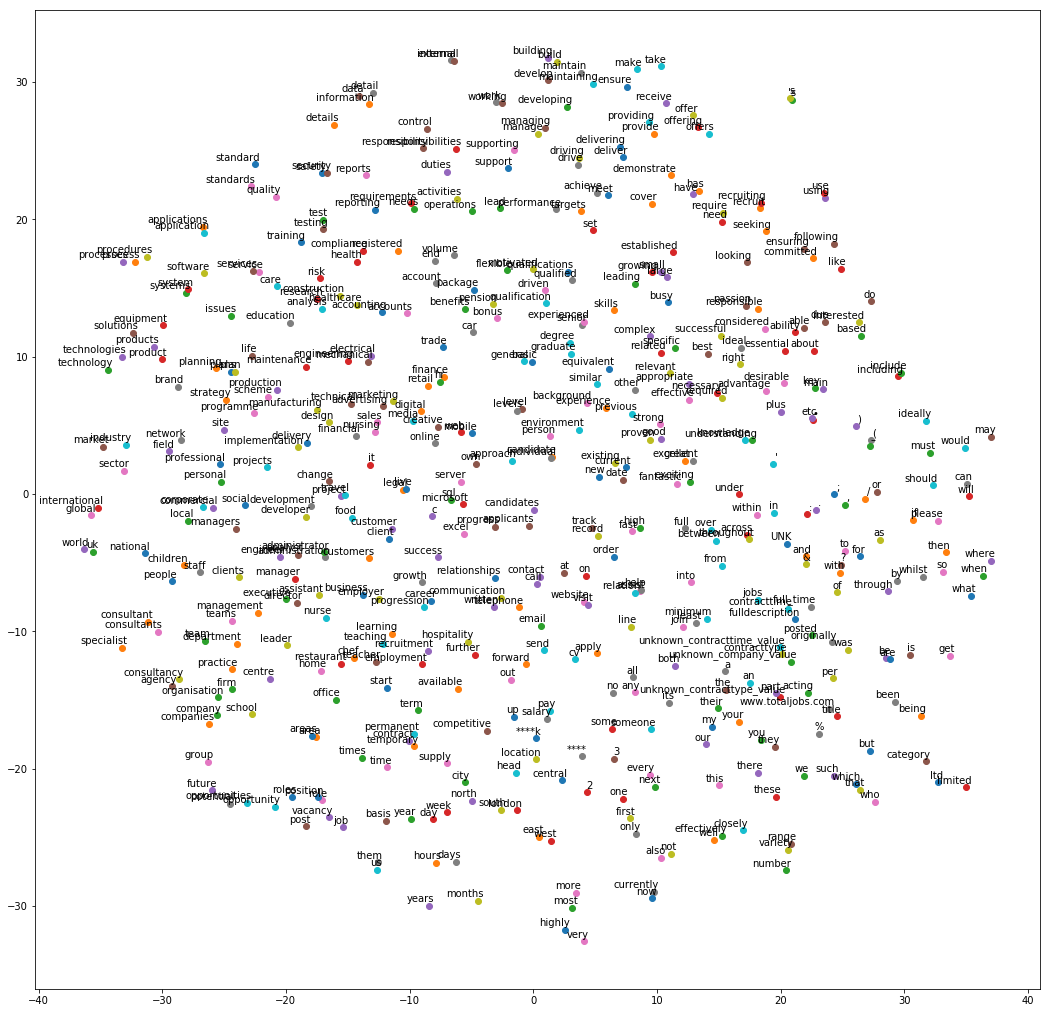

In [112]:
# Step 6: Visualize the embeddings.
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  #plt.show()
  plt.savefig(filename)

try:
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [111]:
print(final_embeddings.shape)
print(labels)
print(final_embeddings)

word2vec = {word: vec for word, vec in zip(labels, final_embeddings)}

import pickle
pickle.dump( word2vec, open( "word2vec.pickle", "wb" ) )

(30000, 256)
['UNK', 'and', ',', ':', '.', 'the', 'to', 'a', 'of', 'in', 'for', 'with', 'you', 'will', 'be', 'is', 'this', '****', 'as', 'an', 'are', 'experience', 'company', 'on', 'have', 'or', 'role', 'work', 'location', 'jobs', 'business', 'your', 'team', 'title', ')', 'category', 'sales', '(', 'contracttype', 'contracttime', 'fulldescription', 'skills', 'we', 'manager', 'our', 'working', 'within', 'all', 'that', 'permanent', 'client', 'management', 'their', 'unknown_contracttype_value', 'recruitment', 'at', 'please', 'development', '&', 'from', 'support', '/', 'uk', 'it', 'job', 'looking', 'service', 'excellent', 'required', 'opportunity', 'new', 'if', 'must', 'london', 'customer', 'services', 'who', 'by', 'successful', 'knowledge', ';', 'apply', 'based', 'ability', 'project', 'they', 'strong', 'other', 'design', 'care', 'ensure', 'candidate', 'high', 'engineering', 'engineer', 'technical', 'join', 'salary', 'not', 'environment', 'training', 'has', 'leading', 'including', 'good', '

In [93]:
def get_word_vec(word):
    return word2vec.get(word, word2vec['UNK'])

def convert_listing(job_listing, word_2_vec_dict=word2vec, include_unk=True):
    array_list = []
    for word in nltk.word_tokenize(job_listing.lower()):
        array_list.append(get_word_vec(word))
    return numpy.average(array_list, axis=0)

def convert_all_listings(job_listing_column, word_2_vec_dict=word2vec, include_unk=True):
    output_list = []
    for job_listing in job_listing_column:
        output_list.append(convert_listing(job_listing))
    return numpy.stack(output_list)
        

In [95]:
examples = input_data[target_column]

#clean_cell(example)

a = convert_all_listings(examples)

print(a.shape)
print(a)

(100, 256)
[[-0.01604152 -0.02295682 -0.01616665 ..., -0.01162046  0.04369759
   0.00555334]
 [-0.02602532 -0.02081161 -0.02054154 ..., -0.01471602  0.05302291
   0.00117728]
 [-0.01130392 -0.02255187 -0.01280118 ..., -0.01006693  0.04060944
   0.00564299]
 ..., 
 [-0.03179402 -0.02920467 -0.01195729 ...,  0.0086424   0.0424469
  -0.00666466]
 [-0.02924498 -0.02723861 -0.01212744 ...,  0.00020881  0.06024467
  -0.00414431]
 [-0.03263325 -0.02478636 -0.01724789 ...,  0.00238428  0.04261065
  -0.00347097]]
